# NOTEBOOK CONTEO PRODUCTOS 

ModelDependencyMissing: Your `inference` configuration does not support PaliGemma model. Use pip install 'inference[transformers]' to install missing requirements.
ModelDependencyMissing: Your `inference` configuration does not support Florence2 model. Use pip install 'inference[transformers]' to install missing requirements.
ModelDependencyMissing: Your `inference` configuration does not support Qwen2.5-VL model. Use pip install 'inference[transformers]' to install missing requirements.
ModelDependencyMissing: Your `inference` configuration does not support SAM model. Use pip install 'inference[sam]' to install missing requirements.
ModelDependencyMissing: Your `inference` configuration does not support SAM model. Use pip install 'inference[sam]' to install missing requirements.
ModelDependencyMissing: Your `inference` configuration does not support SAM model. Use pip install 'inference[clip]' to install missing requirements.
ModelDependencyMissing: Your `inference` configuration does

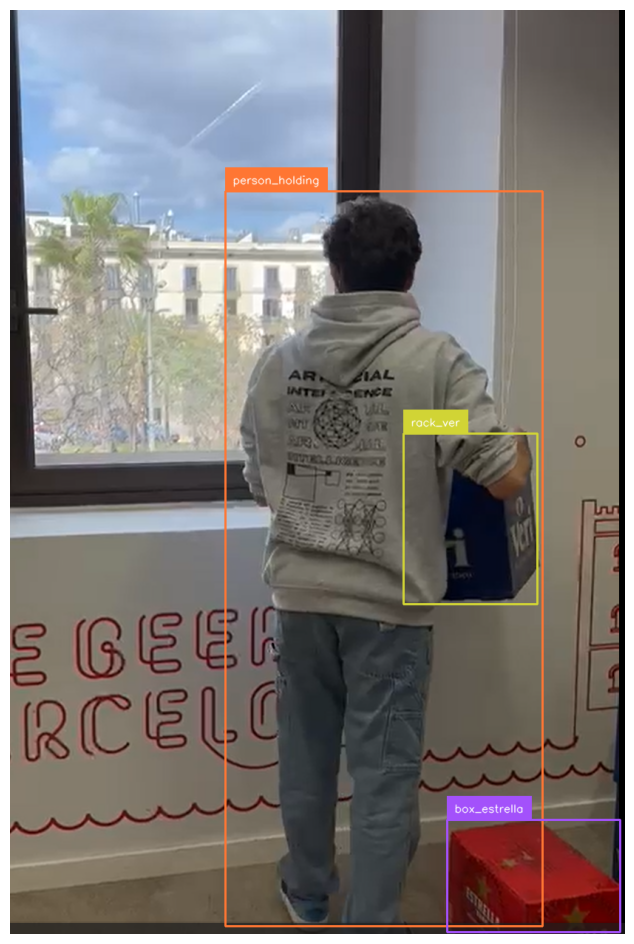

In [1]:
from inference import get_model
import supervision as sv
import cv2

# define the image url to use for inference
image_file = "C:/Users/lolam/Pictures/Screenshots/Captura de pantalla 2025-04-05 135653.png"
image = cv2.imread(image_file)

# load a pre-trained yolov8n model
model = get_model(model_id="repte-3-estrellados/4")

# run inference on our chosen image, image can be a url, a numpy array, a PIL image, etc.
results = model.infer(image)[0]

# load the results into the supervision Detections api
detections = sv.Detections.from_inference(results)

# create supervision annotators
bounding_box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

# annotate the image with our inference results
annotated_image = bounding_box_annotator.annotate(
    scene=image, detections=detections)
annotated_image = label_annotator.annotate(
    scene=annotated_image, detections=detections)

# display the image
sv.plot_image(annotated_image)

Total de fotogramas: 1321


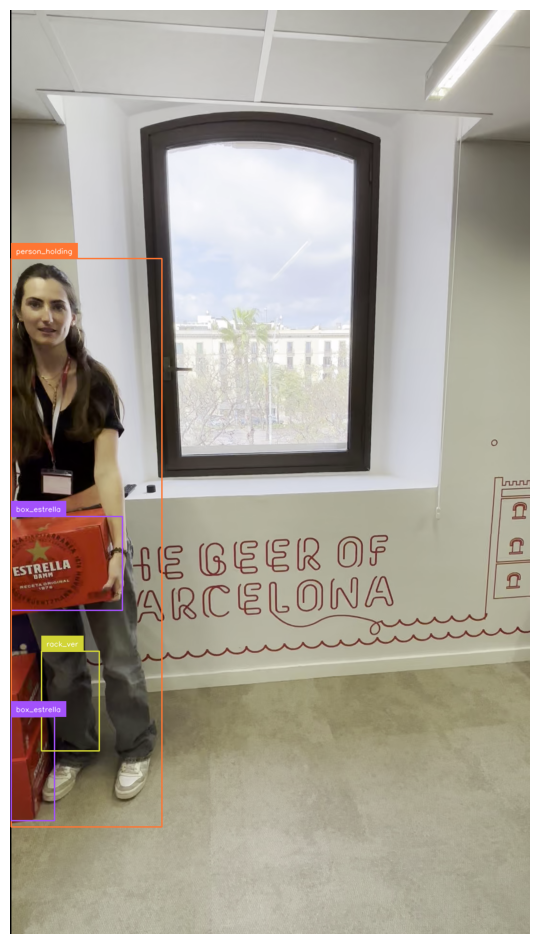

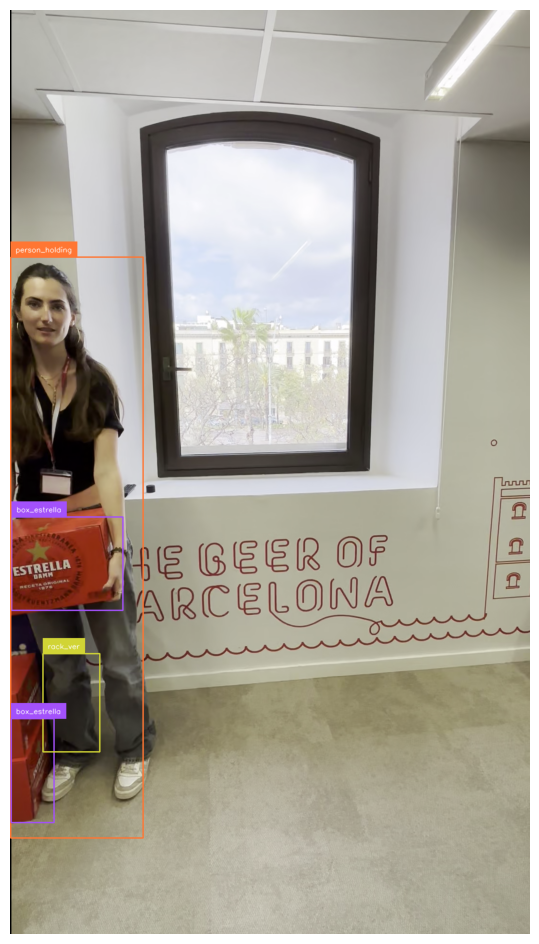

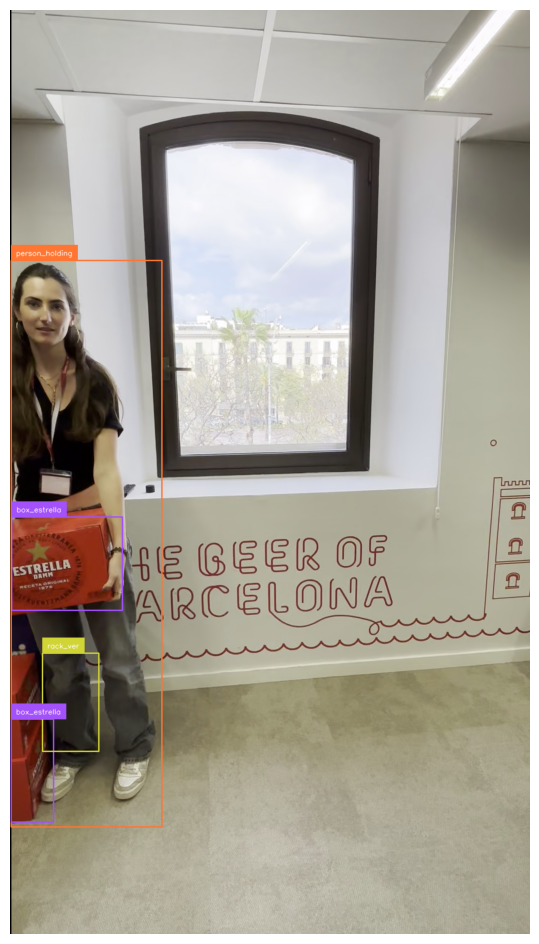

KeyboardInterrupt: 

In [25]:
import cv2
from inference import get_model
import supervision as sv

# Carga del modelo pre-entrenado
model = get_model(model_id="repte-3-estrellados/4")

# Creación de los anotadores (se crean una sola vez para reutilizarlos)
bounding_box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

# Ruta del video a procesar
video_path = "C:/Users/lolam/Downloads/drive-download-20250405T112508Z-001/IMG_5528.MOV"
cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    print("Error al abrir el video.")
    exit()

# Obtiene el total de fotogramas del video
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print(f"Total de fotogramas: {total_frames}")

for i in range(total_frames):
    ret, frame = cap.read()
    if not ret:
        break  # En caso de error o fin del video

    # Realiza la inferencia en el fotograma actual
    results = model.infer(frame)[0]
    
    # Convierte los resultados en detecciones
    detections = sv.Detections.from_inference(results)

    # Anota el fotograma con las detecciones (bounding boxes y etiquetas)
    annotated_frame = bounding_box_annotator.annotate(scene=frame, detections=detections)
    annotated_frame = label_annotator.annotate(scene=annotated_frame, detections=detections)

    # Muestra el fotograma anotado en una ventana
    sv.plot_image(annotated_frame)
    
    # Espera 1 ms y permite salir presionando 'q'
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Libera los recursos y cierra las ventanas
cap.release()
cv2.destroyAllWindows()


In [81]:
import cv2
import math
from inference import get_model
import supervision as sv

def distance(p1, p2):
    return math.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

# Parámetros
DIST_THRESHOLD = 30  
MAX_MISSED_FRAMES = 5

# Cargar modelo
model = get_model(model_id="repte-3-estrellados/4")

# Anotadores
bounding_box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

# Video de entrada
video_path = "C:/Users/lolam/Downloads/video_demo_count.mp4"
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    print("Error al abrir el video.")
    exit()

total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print(f"Total de fotogramas: {total_frames}")

# Mapeo manual de índices a nombres
class_names = {
    0: "box_estrella",
    1: "box_veri",
    2: "person_handfree",
    3: "person_holding",
    4: "rack_ver",
    5: "rack_ver",
    # Agrega más clases según sea necesario
}

# Video de salida
fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
output_path = "C:/Users/lolam/Downloads/output_video.mp4"
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

# Configuración
skip_frames = 1
frame_count = 0

# Contadores
global_count = 0
box_veri_count = 0       
box_estrella_count = 0   
rack_veri_count = 0      

# Lista de detecciones activas en la región: cada elemento es (cx, cy, label, last_seen_frame)
active_detections = []

while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame_count += 1
    if frame_count % skip_frames != 0:
        continue

    # Inferencia
    results = model.infer(frame)[0]
    detections = sv.Detections.from_inference(results)

    # Anotar fotograma
    annotated_frame = bounding_box_annotator.annotate(scene=frame, detections=detections)
    annotated_frame = label_annotator.annotate(scene=annotated_frame, detections=detections)

    # Definir región: entre line_x y line_x+30 (mitad derecha)
    line_x = width // 2
    cv2.line(annotated_frame, (line_x, 0), (line_x, height), (0, 255, 0), 2)
    cv2.line(annotated_frame, (line_x + 30, 0), (line_x + 30, height), (0, 255, 0), 2)

    # Lista de detecciones actuales en la región, con su label: (cx, cy, label)
    current_detections = []

    if detections.xyxy is not None and len(detections.xyxy) > 0:
        for i, box in enumerate(detections.xyxy):
            x_min, y_min, x_max, y_max = box
            cx = (x_min + x_max) / 2
            cy = (y_min + y_max) / 2

            # Obtener label usando detections.class_id y el mapeo
            label_index = detections.class_id[i] if hasattr(detections, "class_id") and detections.class_id is not None else None
            label = class_names.get(label_index, "Unknown") if label_index is not None else "Unknown"

            # Ignorar ciertos labels
            if label in ['person_holding', 'person_handfree']:
                print(f"Detección ignorada: {label}")
                continue

            if line_x <= cx <= line_x + 30:
                current_detections.append((cx, cy, label))
                print(f"Detección: {label} - Centro: ({cx}, {cy})")

    # Procesar detecciones actuales: verificar si son nuevas
    for (cx, cy, label) in current_detections:
        matched = False
        for idx, (ax, ay, a_label, last_seen) in enumerate(active_detections):
            # Si se encuentra una detección activa cercana (y del mismo label)
            if label == a_label and distance((cx, cy), (ax, ay)) < DIST_THRESHOLD:
                matched = True
                active_detections[idx] = (cx, cy, label, frame_count)
                break
        if not matched:
            # Detección nueva: incrementar contadores
            global_count += 1
            if label == "rack_ver":
                rack_veri_count += 1
            elif label == "box_estrella":
                box_estrella_count += 1
            elif label == "box_veri":
                box_veri_count += 1
            # Agregar a detecciones activas
            active_detections.append((cx, cy, label, frame_count))

    # Eliminar detecciones activas no vistas recientemente
    active_detections = [
        (ax, ay, a_label, last_seen)
        for (ax, ay, a_label, last_seen) in active_detections
        if frame_count - last_seen <= MAX_MISSED_FRAMES
    ]

    # Mostrar contadores en el fotograma
    # cv2.putText(annotated_frame, f"Count: {global_count}", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
    cv2.putText(annotated_frame, f"Rack Veri: {rack_veri_count}", (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2.putText(annotated_frame, f"Box Estrella: {box_estrella_count}", (50, 150), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
    cv2.putText(annotated_frame, f"Box Veri: {box_veri_count}", (50, 200), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 0), 2)

    # Escribir fotograma en video de salida
    out.write(annotated_frame)
    # (Opcional) Mostrar en pantalla:
    # cv2.imshow("Frame", annotated_frame)
    # if cv2.waitKey(1) & 0xFF == ord('q'):
    #     break

cap.release()
out.release()
cv2.destroyAllWindows()
print("Video procesado y guardado como:", output_path)


Total de fotogramas: 2210
Detección ignorada: person_holding
Detección ignorada: person_holding
Detección ignorada: person_holding
Detección ignorada: person_holding
Detección ignorada: person_holding
Detección ignorada: person_holding
Detección ignorada: person_holding
Detección ignorada: person_holding
Detección ignorada: person_holding
Detección ignorada: person_holding
Detección ignorada: person_holding
Detección ignorada: person_holding
Detección ignorada: person_holding
Detección ignorada: person_holding
Detección ignorada: person_holding
Detección ignorada: person_holding
Detección ignorada: person_holding
Detección ignorada: person_holding
Detección ignorada: person_holding
Detección ignorada: person_holding
Detección ignorada: person_holding
Detección ignorada: person_holding
Detección ignorada: person_holding
Detección ignorada: person_holding
Detección ignorada: person_holding
Detección ignorada: person_holding
Detección ignorada: person_holding
Detección ignorada: person_ho

KeyboardInterrupt: 